In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy

# Adding library directory to python search path
import sys
import os

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [2]:
class consts:
    dummy = 0

class setup:
    dummy = 0
    tau0 = 8.252 # мкс, период колебаний без сердечника
    dtau = 1e-4 # мкс, погрешность частотототототометра
    dT = 0.01 # *С, погрешность термостата
    dV = 0.005 # мВ, погрешность термопары
    k = 24
    #град/мВ, чувствительность термопары
    

In [3]:
data = mipt.read_excel('data/342.xlsx', usecols=(0,1,2), header=(0)).dropna()
data

,T0,V,tau
0,14.05,-0.015,10.067
1,16.03,-0.019,9.955
2,18.02,-0.018,9.758
3,20.02,-0.019,9.443
4,22.02,-0.019,9.044
5,24.01,-0.019,8.746
6,26.01,-0.019,8.609
7,28.02,-0.019,8.533
8,30.00,-0.019,8.486
9,32.01,-0.018,8.451


`1. Рассчитайте температуру 𝑇 образца с учётом показаний термопары. Постройте график зависимости`

In [4]:
fmt = {
    'T0' : [r'$T_0,^{\circ} C$', '{:.1f}', 0],
    'T'  : [r'$T,^{\circ} C$', '{:.1f}', 0],
    'V' : [r'$V$, мВ', '{:.4f}', 0],
    'tau' : [r'$\tau$, мкс', '{:.2f}', 0],
    'chi' : [r'$\chi$, мкс$^2$', '{:.3f}', 0],
    '1/chi' : [r'$1/\chi$, мкс$^{-2}$', '{:.3f}', 0],
}

T = data['T0'] + data['V'] * setup.k;
chi = data['tau']**2 - setup.tau0**2

dT = (setup.dT**2 + (setup.k * setup.dV)**2)**0.5
dchi = 2*setup.dtau * (data['tau']**2 + setup.tau0**2)**0.5

out = pd.concat([data, T.rename('T'), chi.rename('chi'), (1/chi).rename('1/chi')], axis=1)
tab = mipt.table(out, fmt)
tab.to_latex('gen/tab-1.tex')
tab.rename().data

,"$T_0,^{\circ} C$","$V$, мВ","$\tau$, мкс","$T,^{\circ} C$","$\chi$, мкс$^2$","$1/\chi$, мкс$^{-2}$"
0,14.05,-0.015,10.067,13.690,33.248985,0.030076
1,16.03,-0.019,9.955,15.574,31.006521,0.032251
2,18.02,-0.018,9.758,17.588,27.123060,0.036869
3,20.02,-0.019,9.443,19.564,21.074745,0.047450
4,22.02,-0.019,9.044,21.564,13.698432,0.073001
5,24.01,-0.019,8.746,23.554,8.397012,0.119090
6,26.01,-0.019,8.609,25.554,6.019377,0.166130
7,28.02,-0.019,8.533,27.564,4.716585,0.212018
8,30.00,-0.019,8.486,29.544,3.916692,0.255317
9,32.01,-0.018,8.451,31.578,3.323897,0.300852


17.576661991539623 \pm 0.15269076563152448


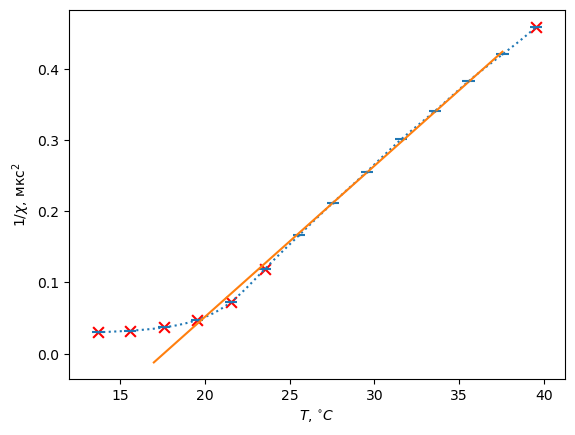

In [7]:
from scipy.interpolate import interp1d
def interp(x, y):
    return interp1d(x, y, kind='cubic')

silent = mipt.plot(T, 1/chi, func=interp, yerr = dchi/(chi**2), xerr = 3*dT, marker_size=1, linestyle=':')
x, y, equ = mipt.plot(T, 1/chi, marker_size=0, exclude=(0,1,2,3,4,5,13), x_min = 17)

curie = op.fsolve(equ, 15)
plt.xlabel(r"$T$, $^{\circ}C$")
plt.ylabel(r"$1/\chi$, мкс$^2$")

plt.savefig('gen/fig-inv.png')

mnk = mipt.mnk(x, y, precision = 3)
mnk.to_latex("gen/tab-mnk.tex")
curie
dcurie = curie[0] * (mnk.data['da'][0]**2 + mnk.data['db'][0]**2)**(0.5)
print(curie[0], "\pm", dcurie)

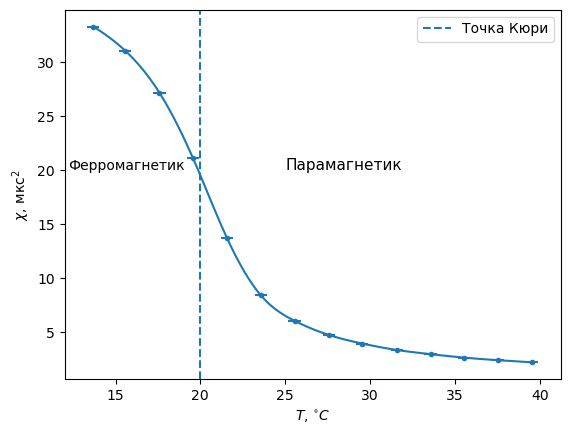

In [11]:
from scipy.interpolate import interp1d
def interp(x, y):
    return interp1d(x, y, kind='cubic')

# Chooooose Curie temperature as you like my little boy
curie = 20

mute = mipt.plot(T, chi, func=interp, marker_size=6, yerr = 3*dchi, xerr = 3*dT, linestyle='-')
plt.axvline(x = curie, linestyle='dashed', label = 'Точка Кюри')
plt.text(curie - 7.8, 20, 'Ферромагнетик', fontsize = 10)
plt.text(curie + 5, 20, 'Парамагнетик', fontsize = 11)

plt.xlabel(r"$T$, $^{\circ}C$")
plt.ylabel(r"$\chi$, мкс$^2$")
plt.legend()

plt.savefig('gen/fig-chi.pdf')